<a href="https://colab.research.google.com/github/mtermor/DL_Fundamentals/blob/main/NN_fundamentals_Solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)

def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Dataset

We have a binary classification dataset. The target `y` has two possible values {0,1} and the input vector `x` has two dimensions.

In [5]:
N = 5000
X, y = load_planar_dataset(N, 0.2)

Visualize the dataset using matbplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. YOur goal is to build a model to fit this data.

'\nc: carray-like or list of colors or color, optional\ny.ravel(): Return a contiguous flattened array (in this case it is equivalent to y)\ncmap: The Colormap instance or registered colormap name used to map scalar data to colors.\n\nX values plotted, coloured by y (like hue in sns library)\n\n'

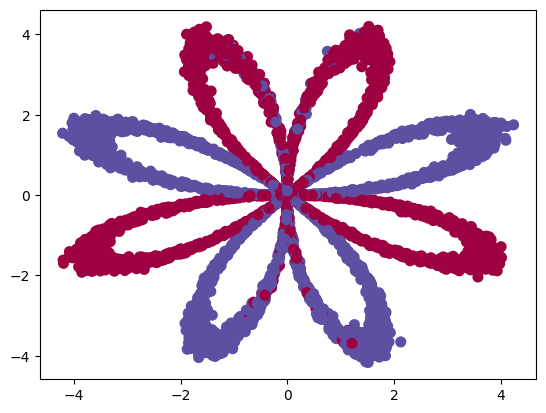

In [16]:
# Visualize the data
plt.scatter(X[:,0], X[:,1], c = y.ravel(), s= 49, cmap= plt.cm.Spectral)

"""
c: carray-like or list of colors or color, optional
y.ravel(): Return a contiguous flattened array (in this case it is equivalent to y)
cmap: The Colormap instance or registered colormap name used to map scalar data to colors.

X values plotted, coloured by y (like hue in sns library)
""";

In [39]:
# Train-test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.2)

In [40]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape, y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [41]:
## X first example
X[0,:]

array([ 3.2975804 , -0.91532219])

In [42]:
## Y firsts examples
y[:8]

array([0, 1, 1, 0, 0, 0, 1, 1], dtype=uint8)

## First NN in Keras

### Logistic regression

Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class. We can specify the number of neurons as the first argument, and specify the activation function using the activation argument.

```python
tf.keras.layers.Dense(
    units, activation=None
)

```

- **units**: Number of neurons in the layer.
- **activation**: Activation function to use, default function is `linear`, you can also use `sigmoid` for sigmoid activation or [other alternatives](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

For defining the input layer you can use `keras.Input(shape=(input_dimension,))` or define your input dimension in the first hidden layer.

```python
layers.Dense(4, activation="sigmoid", input_shape=(input_dimension,))

```

Build a network without hidden layer

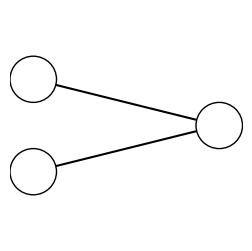

In [43]:
draw_neural_net(0.1, 0.9, 0.1, 0.9, [2,1]) # custom function

In [44]:
### https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

model = keras.Sequential()
# The dimension of the input is 2 (planar data)
# We have only one output layer with 1 neuron
model.add(
    keras.layers.Dense(1, input_shape=(2, ), activation="sigmoid")
)
model.summary()
# 3 parameters: 2 weight parameters + 1 beta

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


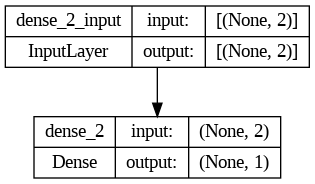

In [45]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes= True)

#### Compile
Now we need to specify the loss function, the metrics and the optimizer. It is done using compile function in Keras.

In [46]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

#### Training model
This is similar to a sklearn model.

In [47]:
model.fit(X_train, y_train, epochs = 10, validation_split = 0.2, batch_size = 32)

"""
ephocs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
        (unless the steps_per_epoch flag is set to something other than None). Note that in conjunction with
        initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations
        given by epochs, but merely until the epoch of index epochs is reached.
batch_size : Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
        Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.PyDataset
        instances (since they generate batches).
validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will
        set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model
        metrics on this data at the end of each epoch. The validation data is selected from the last samples in the
        x and y data provided, before shuffling. This argument is not supported when x is a dataset, generator or
        keras.utils.PyDataset instance. If both validation_data and validation_split are provided, validation_data
        will override validation_split.
""";

Epoch 1/10
100/100 [==============================] - 3s 9ms/step - loss: 1.8715 - accuracy: 0.3159 - val_loss: 1.7950 - val_accuracy: 0.3250
Epoch 2/10
100/100 [==============================] - 0s 2ms/step - loss: 1.7493 - accuracy: 0.3197 - val_loss: 1.6746 - val_accuracy: 0.3250
Epoch 3/10
100/100 [==============================] - 0s 2ms/step - loss: 1.6306 - accuracy: 0.3216 - val_loss: 1.5580 - val_accuracy: 0.3250
Epoch 4/10
100/100 [==============================] - 0s 2ms/step - loss: 1.5148 - accuracy: 0.3259 - val_loss: 1.4431 - val_accuracy: 0.3250
Epoch 5/10
100/100 [==============================] - 0s 2ms/step - loss: 1.4030 - accuracy: 0.3294 - val_loss: 1.3352 - val_accuracy: 0.3250
Epoch 6/10
100/100 [==============================] - 0s 4ms/step - loss: 1.2965 - accuracy: 0.3338 - val_loss: 1.2315 - val_accuracy: 0.3313
Epoch 7/10
100/100 [==============================] - 0s 2ms/step - loss: 1.1958 - accuracy: 0.3388 - val_loss: 1.1347 - val_accuracy: 0.3425
Epoch 

'\nephocs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided \n        (unless the steps_per_epoch flag is set to something other than None). Note that in conjunction with\n        initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations\n        given by epochs, but merely until the epoch of index epochs is reached.\nbatch_size : Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. \n        Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.PyDataset\n        instances (since they generate batches).\nvalidation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will \n        set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model \n        metrics on this data at the end of 

### Making predictions

In [53]:
results = model.evaluate(X_test, y_test, verbose = 0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

"""
Verbosity mode. 0 = silent, 1 = progress bar, 2 = single line.

Outputs: Scalar test loss (if the model has a single output and no metrics) or list of scalars (if the model has
multiple outputs and/or metrics). The attribute model.metrics_names will give you the display labels for the
scalar outputs.

Test loss: to be as small as possible
Test accuracy: to be as large as possible
""";

Test Loss: 0.9034997820854187
Test Accuracy: 0.3869999945163727


In [55]:
y_pred = model.predict(X_test, verbose = 0)
y_pred[:3], y_test[:3]

(array([[0.7797275 ],
        [0.36682343],
        [0.2130463 ]], dtype=float32),
 array([0, 1, 0], dtype=uint8))

32381/32381 [==============================] - 92s 3ms/step


Text(0.5, 1.0, 'Basic NN')

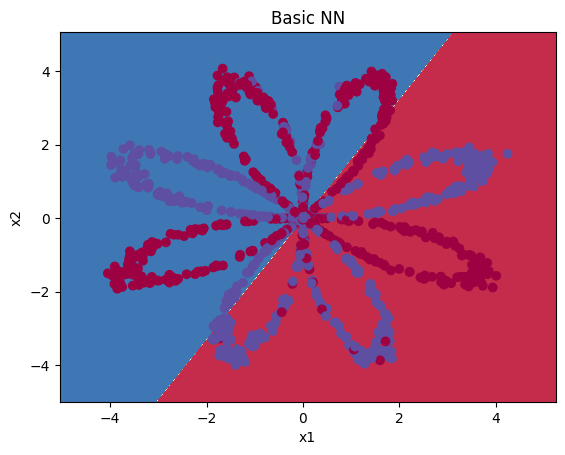

In [59]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN")

### One hidden layer NN

- One **input with 2 features (input_shape)**
- **One hidden dense layer**,  with **3 neurons** and implemented with  **sigmoid activating function**
- **One Output** (sigmoid output activation function)

We can create layers incrementally with the method `add()`:

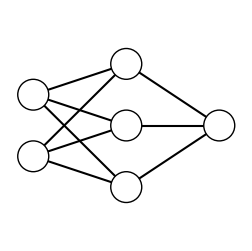

In [60]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 1])

In [61]:
model = keras.Sequential()
model.add(keras.layers.Dense(3, input_shape=(2, ), activation="sigmoid"))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.summary()

# L1 - 9 parameters: 6 weight parameters (6 neuron links) + 3 beta (one per node)
# L2 - 4 parameters: 3 weight parameters (3 neuron links) + 1 beta (one per node)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 3)                 9         
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


You can also define the model with a list of layers
```python
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='sigmoid', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])
````

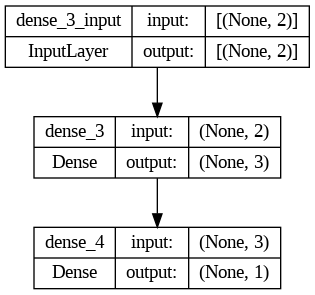

In [62]:
plot_model(model, show_shapes=True)